In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import numpy as np

# From time series analysis to a modified ordinary differential equation

In [ ]:
data = pd.read_csv('/content/BrentOilPrices.csv')
data['Date'] = pd.to_datetime(data['Date']); data

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
9006,2022-11-08,96.85
9007,2022-11-09,93.05
9008,2022-11-10,94.25
9009,2022-11-11,96.37


## Comparing ODE and TSA of petroleum price (2013, 2014, 2015)

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

def run_arima_for_years(data, train_year, actual_years):
    # Initialize the final results DataFrame
    final_df = pd.DataFrame()

    for year in actual_years:
        print(f"Compiling {year} year...")
        train_data = data[data['Date'].dt.year == train_year]['Price'].tolist()
        actual = data[data['Date'].dt.year == year]['Price'].values

        predictions = []
        apes = []
        ape_categories = {'[0, 5%)': 0, '[5%, 7.5%)': 0, '[7.5%, 10%)': 0, '[10%, 1)': 0}

        for actual_value in actual:
            model = ARIMA(train_data, order=(0,1,13))
            model_fit = model.fit()
            prediction = model_fit.forecast()[0]
            predictions.append(prediction)

            ape = abs((actual_value - prediction) / actual_value) * 100
            apes.append(ape)

            if ape < 5:
                ape_categories['[0, 5%)'] += 1
            elif ape < 7.5:
                ape_categories['[5%, 7.5%)'] += 1
            elif ape < 10:
                ape_categories['[7.5%, 10%)'] += 1
            else:
                ape_categories['[10%, 1)'] += 1

            # Update the training set for the next iteration
            train_data.append(actual_value)

        mape = np.mean(apes)

        # Create a DataFrame for the current year's results
        year_results = pd.DataFrame([ape_categories])
        year_results['Year'] = year
        year_results['MAPE'] = mape

        # Append the results
        final_df = pd.concat([final_df, year_results], ignore_index=True)

    # Reorder the columns so 'Year' comes first
    cols = final_df.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    final_df = final_df[cols]

    return final_df

# Usage example:
final_results = run_arima_for_years(data, 2012, [2013, 2014, 2015])

Compiling 2013 year...
Compiling 2014 year...
Compiling 2015 year...


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

,0,1,2
Year,2013.00000,2014.00000,2015.000000
MAPE,0.87215,0.83733,2.824237
"[0, 5%)",252.00000,253.00000,233.000000
"[5%, 7.5%)",0.00000,0.00000,14.000000
"[7.5%, 10%)",0.00000,1.00000,2.000000
"[10%, 1)",0.00000,0.00000,6.000000


In [ ]:
def calculate_ode_results(data, years):
    final_results = pd.DataFrame()

    for year in years:
        df_year = data[data['Date'].dt.year == year].copy()
        df_year.sort_values('Date', inplace=True)

        # Initial ODE result using the first price
        ode_results = [df_year['Price'].iloc[0]]

        # Calculate ODE results for the rest of the year
        for i in range(1, len(df_year)):
            dt = 1  # Assuming a daily timestep, can be adjusted if needed
            a = (1 / dt) * np.log(df_year['Price'].iloc[i] / df_year['Price'].iloc[i-1])
            yi_plus_1 = df_year['Price'].iloc[i] * np.exp(a * dt)
            ode_results.append(yi_plus_1)

        # Calculate APE for each prediction
        actual_prices = df_year['Price'].values
        apes_ode = [abs((a - p) / a) * 100 for a, p in zip(actual_prices[2:], ode_results[1: -1])]

        # Calculate MAPE
        mape_ode = np.mean(apes_ode)

        # Categorize APE
        ape_categories_ode = {'[0, 5%)': 0, '[5%, 7.5%)': 0, '[7.5%, 10%)': 0, '[10%, 1)': 0}
        for ape in apes_ode:
            if ape < 5:
                ape_categories_ode['[0, 5%)'] += 1
            elif ape < 7.5:
                ape_categories_ode['[5%, 7.5%)'] += 1
            elif ape < 10:
                ape_categories_ode['[7.5%, 10%)'] += 1
            else:
                ape_categories_ode['[10%, 1)'] += 1

        # Append results for this year to the final DataFrame
        year_results = pd.DataFrame([ape_categories_ode])
        year_results['Year'] = year
        year_results['MAPE'] = mape_ode
        year_results['Model'] = 'ODE'
        final_results = pd.concat([final_results, year_results], ignore_index=True)

    return final_results

# Example usage:
final_ode_results = calculate_ode_results(data, [2013, 2014, 2015])

,0,1,2
"[0, 5%)",249,249,216
"[5%, 7.5%)",1,3,31
"[7.5%, 10%)",0,0,6
"[10%, 1)",0,0,0
Year,2013,2014,2015
MAPE,1.182426,1.242685,2.680166
Model,ODE,ODE,ODE


In [ ]:
ode_arima_res = pd.DataFrame()
ode_arima_res['ODE'] = final_ode_results.loc[0].drop("Model")
ode_arima_res['TSA'] = final_results.loc[0]
ode_arima_res

,ODE,TSA
"[0, 5%)",249,252.00000
"[5%, 7.5%)",1,0.00000
"[7.5%, 10%)",0,0.00000
"[10%, 1)",0,0.00000
Year,2013,2013.00000
MAPE,1.182426,0.87215


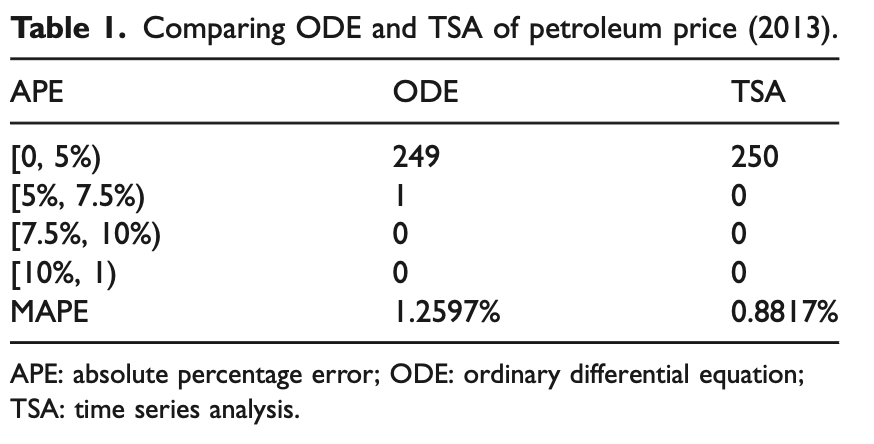

In [ ]:
ode_arima_res = pd.DataFrame()
ode_arima_res['ODE'] = final_ode_results.loc[1].drop("Model")
ode_arima_res['TSA'] = final_results.loc[1]
ode_arima_res

,ODE,TSA
"[0, 5%)",249,253.00000
"[5%, 7.5%)",3,0.00000
"[7.5%, 10%)",0,1.00000
"[10%, 1)",0,0.00000
Year,2014,2014.00000
MAPE,1.242685,0.83733


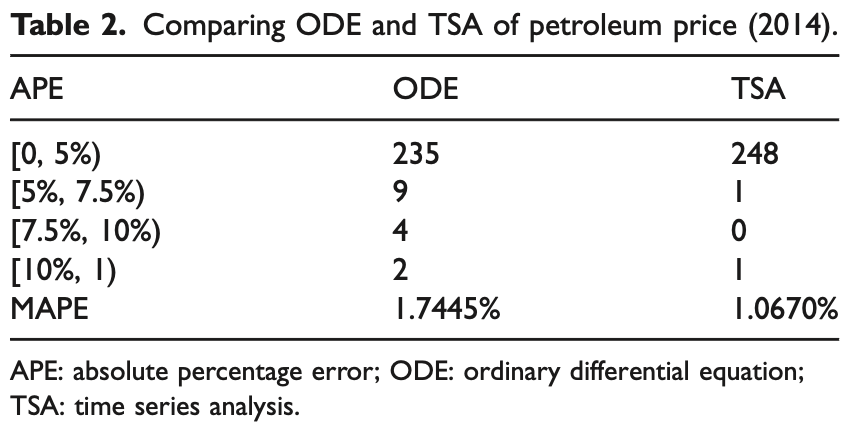

In [ ]:
ode_arima_res = pd.DataFrame()
ode_arima_res['ODE'] = final_ode_results.loc[2].drop("Model")
ode_arima_res['TSA'] = final_results.loc[2]
ode_arima_res

,ODE,TSA
"[0, 5%)",216,233.000000
"[5%, 7.5%)",31,14.000000
"[7.5%, 10%)",6,2.000000
"[10%, 1)",0,6.000000
Year,2015,2015.000000
MAPE,2.680166,2.824237


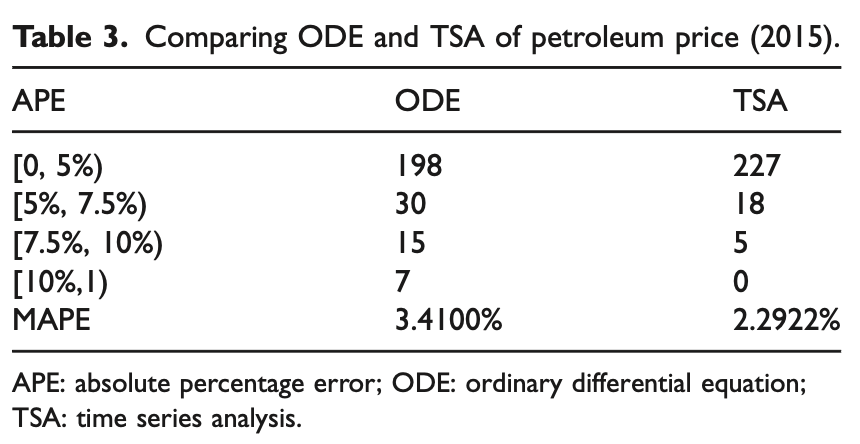

# Runge - Kutta Method for Tables 6 - 11

In [ ]:
df = data
df_2012 = df[df['Date'].dt.year == 2012]
df_2013 = df[df['Date'].dt.year == 2013]
df_2014 = df[df['Date'].dt.year == 2013]
df_2015 = df[df['Date'].dt.year == 2013]

In [ ]:
def g_2013(t, y, M=0, N=1):
    # Coefficients for the polynomial part
    a = [-0.03031, 0.00001]

    # Coefficients for the sinusoidal part
    b = [2.90619, 0.24353, -0.17368, 0.11570]

    # Phase shifts for the sinusoidal part
    c = [0, -4.50499, -11.26577, -15.31979]

    theta = 0.49755

    # Calculate the polynomial part
    poly_part = sum(a[i] * t**i for i in range(0, M + 1)) * y

    # Calculate the sinusoidal part
    sin_part = sum((b[j] * np.sin(2 * np.pi * j * y / theta + c[j])) for j in range(1, N + 1))

    return poly_part + b[0] + sin_part

def rk4_step(g, tn, yn, h, M, N):

    k1 = g(tn, yn, m, n)
    # print("k1", k1)
    k2 = g(tn + 0.5 * h, yn + 0.5 * h * k1, m, n)
    # print("k2", k2)
    k3 = g(tn + 0.5 * h, yn + 0.5 * h * k2, m, n)
    # print("k3", k3)
    # k4 = g(tn + h, yn + h * k3)

    yn_plus_1 = yn + (h / 6) * (k1 + 4 * k2 + k3)

    return yn_plus_1

import numpy as np
import pandas as pd

res = [[0 for i in range(4)] for i in range(4)]
print(res)
for m in range(0, 2):
  for n in range(1, 4):
    predictions = [df_2013['Price'].iloc[0]]

    for i in range(1, len(df_2013)):
        t = i
        t_next = i+1
        y = df_2013['Price'].iloc[i - 1]
        h = 1

        y_next = rk4_step(g_2013, t, y, h, m, n)
        predictions.append(y_next)


    df_2013['y_pred'] = predictions

    mape = np.mean(np.abs((df_2013['Price'] - df_2013['y_pred']) / df_2013['Price'])) * 100

    print("MAPE for the 2013 data:", mape)
    res[m][n] = np.round(mape, 5)

[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
MAPE for the 2013 data: 0.89173686013657
MAPE for the 2013 data: 0.889198421320035
MAPE for the 2013 data: 0.8975204807284467
MAPE for the 2013 data: 0.8669279030800299
MAPE for the 2013 data: 0.8710464659392785
MAPE for the 2013 data: 0.8799441814369069


In [ ]:
sliced_matrix = [row[1:] for row in res]
sliced_matrix[1][0] = "Singular"
for i in range(len(sliced_matrix)):
  for j in range(len(sliced_matrix[i])):
    if sliced_matrix[i][j] == 0:
      sliced_matrix[i][j] = "Singular"

print("MAPE of petroleum 2013 prices, according to eqution 12")
print(*sliced_matrix, sep='\n')

MAPE of petroleum 2013 prices, according to eqution 12
[0.89174, 0.8892, 0.89752]
['Singular', 0.87105, 0.87994]
['Singular', 'Singular', 'Singular']
['Singular', 'Singular', 'Singular']


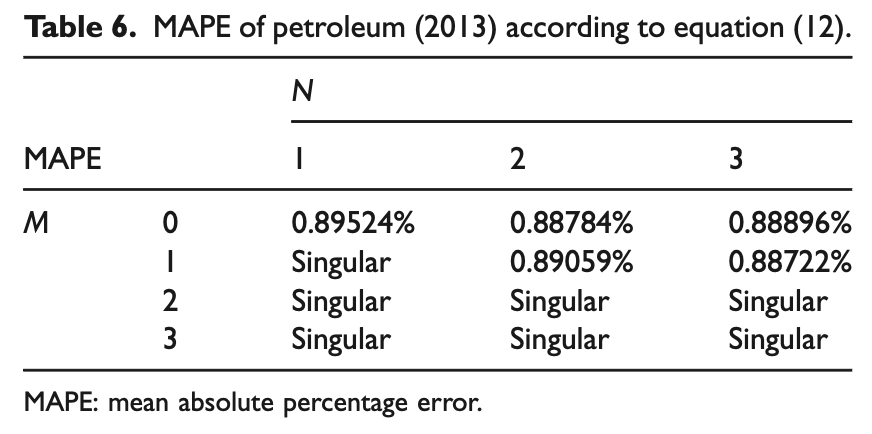

In [ ]:
def g_2013(t, y, M=0, N=1):
    # Coefficients for the polynomial part
    a = [0.01215, 0]

    # Coefficients for the sinusoidal part
    b = [-1.30755, -0.22307, 0]

    # Phase shifts for the sinusoidal part
    c = [398.30817, 0, 0]

    theta = 0.74135

    # Calculate the polynomial part
    poly_part = sum(a[i] * t**i for i in range(M)) * y

    # Calculate the sinusoidal part
    sin_part = sum((b[j] * np.sin(2 * np.pi * j * y / theta + c[j])) for j in range(N))

    return poly_part + b[0] + sin_part

def rk4_step(g, tn, yn, h, M, N):

    k1 = g(tn, yn, m, n)
    # print("k1", k1)
    k2 = g(tn + 0.5 * h, yn + 0.5 * h * k1, m, n)
    # print("k2", k2)
    k3 = g(tn + 0.5 * h, yn + 0.5 * h * k2, m, n)
    # print("k3", k3)
    # k4 = g(tn + h, yn + h * k3)

    yn_plus_1 = yn + (h / 6) * (k1 + 4 * k2 + k3)

    return yn_plus_1

import numpy as np
import pandas as pd

res = [[0 for i in range(4)] for i in range(4)]
# print(res)
for m in range(0, 2):
  for n in range(1, 4):
    predictions = [df_2013['Price'].iloc[0]]

    for i in range(1, len(df_2013)):
        t = i
        t_next = i+1
        y = df_2013['Price'].iloc[i - 1]
        h = 1

        y_next = rk4_step(g_2013, t, y, h, m, n)
        predictions.append(y_next)


    df_2013['y_pred'] = predictions

    mape = np.mean(np.abs((df_2013['Price'] - df_2013['y_pred']) / df_2013['Price'])) * 100

    print("MAPE for the 2013 data:", mape)
    res[m][n] = np.round(mape, 5)

sliced_matrix = [row[1:] for row in res]
sliced_matrix = sliced_matrix[1:]
for i in range(len(sliced_matrix)):
  for j in range(len(sliced_matrix[i])):
    if sliced_matrix[i][j] == 0:
      sliced_matrix[i][j] = "Singular"

print("MAPE of petroleum 2014 prices, according to eqution 12")
print(*sliced_matrix, sep='\n')

MAPE for the 2013 data: 1.9817351191670516
MAPE for the 2013 data: 1.965935581140742
MAPE for the 2013 data: 1.965935581140742
MAPE for the 2013 data: 1.0693478732282096
MAPE for the 2013 data: 1.079857309569009
MAPE for the 2013 data: 1.079857309569009
MAPE of petroleum 2014 prices, according to eqution 12
[1.06935, 1.07986, 1.07986]
['Singular', 'Singular', 'Singular']
['Singular', 'Singular', 'Singular']


In [ ]:
def g_2013(t, y, M=0, N=1):
    # Coefficients for the polynomial part
    a = [-0.02185, -0.00004]

    # Coefficients for the sinusoidal part
    b = [1.26420, 0.16355, 0]

    # Phase shifts for the sinusoidal part
    c = [12.81797, 0, 0]

    theta = 0.46282

    # Calculate the polynomial part
    poly_part = sum(a[i] * t**i for i in range(M)) * y

    # Calculate the sinusoidal part
    sin_part = sum((b[j] * np.sin(2 * np.pi * j * y / theta + c[j])) for j in range(N))

    return poly_part + b[0] + sin_part

def rk4_step(g, tn, yn, h, M, N):

    k1 = g(tn, yn, m, n)
    # print("k1", k1)
    k2 = g(tn + 0.5 * h, yn + 0.5 * h * k1, m, n)
    # print("k2", k2)
    k3 = g(tn + 0.5 * h, yn + 0.5 * h * k2, m, n)
    # print("k3", k3)
    # k4 = g(tn + h, yn + h * k3)

    yn_plus_1 = yn + (h / 6) * (k1 + 4 * k2 + k3)

    return yn_plus_1

import numpy as np
import pandas as pd

res = [[0 for i in range(4)] for i in range(4)]
# print(res)
for m in range(0, 2):
  for n in range(1, 4):
    predictions = [df_2013['Price'].iloc[0]]

    for i in range(1, len(df_2013)):
        t = i
        t_next = i+1
        y = df_2013['Price'].iloc[i - 1]
        h = 1

        y_next = rk4_step(g_2013, t, y, h, m, n)
        predictions.append(y_next)


    df_2013['y_pred'] = predictions

    mape = np.mean(np.abs((df_2013['Price'] - df_2013['y_pred']) / df_2013['Price'])) * 100

    print("MAPE for the 2013 data:", mape)
    res[m][n] = np.round(mape, 5)

sliced_matrix = [row[1:] for row in res]

for i in range(len(sliced_matrix)):
  for j in range(len(sliced_matrix[i])):
    if sliced_matrix[i][j] == 0:
      sliced_matrix[i][j] = "Singular"

print("MAPE of petroleum 2015 prices, according to eqution 12")
print(*sliced_matrix, sep='\n')

MAPE for the 2013 data: 1.5556857603894774
MAPE for the 2013 data: 1.5917419410133002
MAPE for the 2013 data: 1.5917419410133002
MAPE for the 2013 data: 1.0637381087287265
MAPE for the 2013 data: 1.0750123172392874
MAPE for the 2013 data: 1.0750123172392874
MAPE of petroleum 2015 prices, according to eqution 12
[1.55569, 1.59174, 1.59174]
[1.06374, 1.07501, 1.07501]
['Singular', 'Singular', 'Singular']
['Singular', 'Singular', 'Singular']


# Comparison of final results

In [ ]:
# Results pasted from above code
MAPE_Compare = {
                "Petroleum 2013": [0.87215, 1.182426],
                "Petroleum 2014": [0.83733, 1.242685],
                "Petroleum 2015": [2.824237, 2.680166],
}

MAPE_Compare


{'Petroleum 2013': [0.87215, 1.182426],
 'Petroleum 2014': [0.83733, 1.242685],
 'Petroleum 2015': [2.824237, 2.680166]}

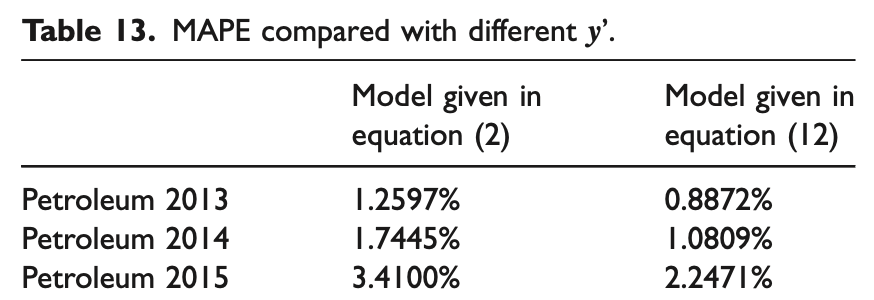